# A/B Testing and Hypothesis Prioritization

## 1. Project Description 

**Context.** I’m an analyst at an online store. Together with Marketing we compiled a list of hypotheses to grow revenue.

**Available data.**
- `hypotheses_us.csv` — Hypothesis, Reach, Impact, Confidence, Effort.
- `orders_us.csv` — transactionId, visitorId, date, revenue, group.
- `visits_us.csv` — date, group, visits (daily aggregated).

**Main tasks.**
1) Prioritize hypotheses with **ICE** and **RICE** and explain the difference.
2) Run an **A/B test** and analyze:
   - Cumulative revenue, AOV, conversion.
   - Daily conversion.
   - Outliers: orders/user and order price (P95 / P99).
   - Statistical significance (RAW & FILTERED): conversion and AOV.
   - Final decision: stop/continue and which group leads.

**Tools & libraries.** Python, pandas, numpy, scipy, plotly (interactive charts).

## 2. Project Roadmap  

1) **Step 1 — Data Prep:** load datasets, quick overview, convert dates, sanity checks, remove cross-group users (keep **RAW** + crossers-removed).
2) **Step 2 — Prioritization:** compute **ICE/RICE**, rank, compare, select hypothesis.
3) **Step 3 — A/B (RAW):** cumulative revenue & AOV (+ relative diff), daily & cumulative conversion (stability), outlier exploration (orders/user, price), significance tests (conversion, AOV).
4) **Step 4 — A/B (FILTERED):** apply anomaly filters (users with **≥5** orders; orders **> 901**), cumulative conversion (stability), significance tests (conversion, AOV).
5) **Step 5 — Final Decision:** concise recommendation (stop/continue; leader) + short rollout note.

*All plots are interactive (Plotly)

## Step 1. Data Overview and Preprocessing

### 1.1. Imports

In [32]:
# Import libraries
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.io as pio
import scipy.stats as stats

In [61]:
# Setting up standard visual of charts
px.defaults.template = "plotly_white"
COLORS = {"A": "#4BA3C3", "B": "#0F349D"}
pio.templates["plotly_white"].layout.update(
    width=1100,
    height=500
);

### 1.2. Helper functions

In [34]:
def dataset_overview(df, name="df", head_rows=5):
    """Prints: shape, columns, dtypes (via df.info), missing (count/%), duplicates, head.
    """
    print(f"=== Dataset overview: {name} ===")

    # 1) Size
    print(f"Shape: {df.shape[0]} rows x {df.shape[1]} columns")

    # 2) Columns
    print("\nColumns:")
    print(list(df.columns))

    # 3) Dtypes & memory
    print("\nDtypes & memory usage (df.info()):")
    df.info()

    # 4) Missing values
    print("\nMissing values per column:")
    missing = df.isna().sum()
    if missing.sum() == 0:
        print("No missing values.")
    else:
        missing_pct = (missing / len(df) * 100).round(2)
        summary = pd.DataFrame({"missing": missing, "missing_%": missing_pct})
        summary = summary[summary["missing"] > 0].sort_values("missing_%", ascending=False)
        display(summary)

    # 5) Full-row duplicates
    print("\nDuplicate rows (full row duplicate):", df.duplicated().sum())

    # 6) Preview
    print(f"\nHead ({head_rows} rows):")
    display(df.head(head_rows))

    print("\n=== End ===\n")

def convert_date(df, col):
    """Convert df[col] to pandas datetime in place; report how many values became NaT."""
    before = df[col].copy()
    df[col] = pd.to_datetime(df[col], errors="coerce")
    bad = int((before.notna() & df[col].isna()).sum())
    print(f"[{col}] converted to datetime | invalid → NaT: {bad}")

def sanity_checks_ab(orders, visits):
    """Run basic read-only checks for A/B datasets 
    (groups, non-negative metrics, duplicates, date ranges)."""
   
    # Groups
    print("=== Groups ===")
    print("orders:", sorted(orders["group"].dropna().unique()))
    print("visits:", sorted(visits["group"].dropna().unique()))

    # Non-negative metrics
    print("\n=== Non-negative metrics ===")
    print("negative revenue in orders:", (orders["revenue"] < 0).sum())
    print("negative visits in visits:", (visits["visits"] < 0).sum())

    # Duplicates
    print("\n=== Duplicates ===")
    print("duplicate transactionId in orders:", orders["transactionId"].duplicated().sum())
    print("duplicate (date, group) rows in visits:", visits.duplicated(subset=["date", "group"]).sum())

    # Date ranges
    print("\n=== Date ranges ===")
    print("orders:", orders["date"].min(), "->", orders["date"].max())
    print("visits:", visits["date"].min(), "->", visits["date"].max())

def check_cross_group_users(orders_df, show_examples=5):
    """Do any users appear in both A and B?
    Prints count and a few examples. Returns the set of user IDs.
    Uses np.intersect1d for the intersection.
    """
    # Unique user lists per group
    ids_A = orders_df.loc[orders_df['group'] == 'A', 'visitorId'].unique()
    ids_B = orders_df.loc[orders_df['group'] == 'B', 'visitorId'].unique()

    # Intersection via numpy
    crossers_arr = np.intersect1d(ids_A, ids_B, assume_unique=False)

    crossers = set(crossers_arr)

    total_users = orders_df['visitorId'].nunique()
    
    print(f"Users in both A and B: {len(crossers)} of {total_users}")
    
    if show_examples and len(crossers) > 0:
        print("Examples:", sorted(crossers)[:show_examples])

    return crossers

In [35]:
# Load datasets 
hypotheses = pd.read_csv("hypotheses_us.csv", sep=";")
orders = pd.read_csv("orders_us.csv")
visits = pd.read_csv("visits_us.csv")

In [36]:
# Quick overview (before conversions) 
dataset_overview(orders, "orders")
dataset_overview(visits, "visits")

=== Dataset overview: orders ===
Shape: 1197 rows x 5 columns

Columns:
['transactionId', 'visitorId', 'date', 'revenue', 'group']

Dtypes & memory usage (df.info()):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   transactionId  1197 non-null   int64  
 1   visitorId      1197 non-null   int64  
 2   date           1197 non-null   object 
 3   revenue        1197 non-null   float64
 4   group          1197 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 46.9+ KB

Missing values per column:
No missing values.

Duplicate rows (full row duplicate): 0

Head (5 rows):


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B



=== End ===

=== Dataset overview: visits ===
Shape: 62 rows x 3 columns

Columns:
['date', 'group', 'visits']

Dtypes & memory usage (df.info()):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    62 non-null     object
 1   group   62 non-null     object
 2   visits  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB

Missing values per column:
No missing values.

Duplicate rows (full row duplicate): 0

Head (5 rows):


,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756



=== End ===



In [37]:
# Convert date columns to datetime 
convert_date(orders, "date")
convert_date(visits, "date")

# Check the result
print(orders['date'].dtype)
print(visits['date'].dtype)

[date] converted to datetime | invalid → NaT: 0
[date] converted to datetime | invalid → NaT: 0
datetime64[ns]
datetime64[ns]


In [38]:
# Sanity checks
sanity_checks_ab(orders, visits)

=== Groups ===
orders: ['A', 'B']
visits: ['A', 'B']

=== Non-negative metrics ===
negative revenue in orders: 0
negative visits in visits: 0

=== Duplicates ===
duplicate transactionId in orders: 0
duplicate (date, group) rows in visits: 0

=== Date ranges ===
orders: 2019-08-01 00:00:00 -> 2019-08-31 00:00:00
visits: 2019-08-01 00:00:00 -> 2019-08-31 00:00:00


In [39]:
# Check for cross-group users (both A and B)
crossers = check_cross_group_users(orders)

Users in both A and B: 58 of 1031
Examples: [np.int64(8300375), np.int64(199603092), np.int64(232979603), np.int64(237748145), np.int64(276558944)]


**Data caveat — cross-group users.**  
The `visits` table is aggregated by (date, group) and does not contain user IDs.  
Removing cross-group users **only** from `orders` makes numerator/denominator slightly inconsistent.  
Given the small number of crossers, they can be **kept** as is for the main analysis; the effect on conclusions is expected to be minor. 

In [40]:
# Remove cross-group users from orders 
orders_raw = orders.copy()
orders_filtered = orders[~orders['visitorId'].isin(crossers)].copy()

print("Removed orders rows:", len(orders_raw) - len(orders_filtered))
print("Unique users removed:", len(crossers))

# Sanity: after filtering, each user must belong to exactly one group

max_groups = orders_filtered.groupby('visitorId')['group'].nunique().max()
print("Max groups per user (should be 1):", int(max_groups))

# Quick counts by group (before/after) — for transparency
print("\nOrders per group (raw):")
print(orders_raw["group"].value_counts().to_string())

print("\nOrders per group (filtered):")
print(orders_filtered["group"].value_counts().to_string())

Removed orders rows: 181
Unique users removed: 58
Max groups per user (should be 1): 1

Orders per group (raw):
group
B    640
A    557

Orders per group (filtered):
group
B    548
A    468


### Summary — Step 1 (Data Overview & Preprocessing)

- Loaded: `hypotheses`, `orders`, `visits`.
- Converted `date` ->`datetime64[ns]` (orders, visits).
- Checks OK: no missing; no full-row duplicates; `visits` has 1 row per `(date, group)`; no negative `revenue`/`visits`; groups = A/B.
- Cross-group users in `orders`: **58 / 1031** -> removed from both groups  -> **181** orders dropped.
- Kept datasets: `orders_raw` (original), `orders_filtered` (clean). `visits` left as-is (daily aggregates).

## Step 2. Prioritization (ICE / RICE) 

- **ICE** prioritizes by: **Impact × Confidence / Effort**.  
  Higher when the expected effect is strong and believable, and effort is low.
- **RICE** adds **Reach**: **Reach × Impact × Confidence / Effort**.  
  Same logic as ICE, but ideas touching **more users** move up.
- **Why rankings change:** a hypothesis with moderate effect but **high Reach** can outrank a strong but **narrow** idea.
- **What to do with ties/close scores:** pick the **lower Effort** first or run a quick experiment to learn faster.

In [41]:
# Helpers for Step 2

def compute_ice_rice(df, round_to=2):
    """
    Compute ICE and RICE in place.
    ICE  = (Impact * Confidence) / Effort
    RICE = (Reach  * Impact * Confidence) / Effort
    """
    df['ICE']  = (df['Impact'] * df['Confidence']) / df['Effort']
    df['RICE'] = (df['Reach']  * df['Impact'] * df['Confidence']) / df['Effort']
   
    df['ICE']  = df['ICE'].round(round_to)
    df['RICE'] = df['RICE'].round(round_to)
    pd.options.display.max_colwidth = 210
    return df  


def build_rank_compare(df):
    """
    Assign ranks for ICE and RICE and build a comparison table.
    Positive 'change' means the hypothesis moved UP under RICE.
    Returns a DataFrame sorted by RICE_rank.
    """
    tmp = df.copy()
    tmp['ICE_rank']  = tmp['ICE'].rank(ascending=False, method="dense").astype(int)
    tmp['RICE_rank'] = tmp['RICE'].rank(ascending=False, method="dense").astype(int)
    compare = (tmp[['Hypothesis','Reach','ICE','RICE','ICE_rank','RICE_rank']]
               .assign(change=lambda d: d["ICE_rank"] - d["RICE_rank"])
               .sort_values('RICE_rank')
               .reset_index(drop=True))
    return compare

In [42]:
# Compute scores
compute_ice_rice(hypotheses)

# Show how prioritization changes (ICE -> RICE)
compare = build_rank_compare(hypotheses)
display(compare)

,Hypothesis,Reach,ICE,RICE,ICE_rank,RICE_rank,change
0,Add a subscription form to all the main pages. This will help you compile a mailing list,10,11.20,112.0,3,1,2
1,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,7.00,56.0,5,2,3
2,Add two new channels for attracting traffic. This will bring 30% more users,3,13.33,40.0,2,3,-1
3,Show banners with current offers and sales on the main page. This will boost conversion,5,8.00,40.0,4,3,1
4,Launch a promotion that gives users discounts on their birthdays,1,16.20,16.2,1,4,-3
5,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,1.12,9.0,8,5,3
6,Launch your own delivery service. This will shorten delivery time,2,2.00,4.0,6,6,0
7,Add a customer review page. This will increase the number of orders,3,1.33,4.0,7,6,1
8,Change the background color on the main page. This will increase user engagement,3,1.00,3.0,9,7,2


### How prioritization changes (RICE vs ICE)

**RICE = (Reach × Impact × Confidence) / Effort**, so adding **Reach** lifts broad-impact ideas and pushes down narrow ones.

- **Up:** Subscription form (ICE #3 -> RICE #1, +2), Recommendations ( #5 -> #2, +3), Category structure ( #8 -> #5, +3).  
- **Down:** Birthday promo ( #1 -> #4, −3), Two new channels ( #2 -> #3, −1).  
- **Net:** High-reach hypotheses move up; low-reach ones drop even with strong Impact/Confidence.

**Chosen priority (for future testing):** By RICE, the first to test would be  
“Add a subscription form to all the main pages” (RICE=112.0, ICE=11.2).

In [43]:
# Plot
px.defaults.template = "plotly_white"

fig = px.scatter(
    hypotheses,
    x="Effort", y="RICE",
    size="Reach",
    color="Confidence", color_continuous_scale="Blues",
    hover_name="Hypothesis",
    hover_data={"Effort": True, "RICE": ":.2f", "Reach": True, "Confidence": True},
    title="Hypotheses — RICE vs Effort (size=Reach, color=Confidence)"
)
fig.update_traces(marker=dict(opacity=0.85, line=dict(width=0)))  # cleaner markers
fig.update_xaxes(title="Effort (lower is better)")
fig.update_yaxes(title="RICE (higher is better)")
fig.show()

## Step 3. A/B Test Analysis

#### 3.1. Cumulative revenue by group (RAW)

In [44]:
def build_cumulative_data(orders_df, visits_df):
    """
    Build cumulative daily table by (date, group).
    Returns columns: date, group, orders, buyers, revenue, visitors.
    Notes:
    - 'buyers' is cumulative unique users (nunique over all days <= date).
    """
    # Unique (date, group) pairs to iterate
    datesGroups = orders_df[["date", "group"]].drop_duplicates().sort_values(["date","group"])

    # Cumulative orders/revenue/buyers
    ordersAggregated = (datesGroups
    .apply(lambda x: orders_df[np.logical_and(orders_df['date'] <= x['date'], orders_df['group'] == x['group'])]
    .agg({'date' : 'max', 'group' : 'max', 'transactionId' : 
          pd.Series.nunique, 'visitorId' : 
          pd.Series.nunique, 'revenue' : 'sum'}), axis=1)
    .sort_values(by=['date','group'])
                   )

    # Cumulative visits
    visitorsAggregated = (datesGroups
    .apply(lambda x: visits_df[np.logical_and(visits_df['date'] <= x['date'], visits_df['group'] == x['group'])]
        .agg({'date' : 'max', 'group' : 'max', 'visits' : 'sum'}), axis=1)
    .sort_values(by=['date','group'])
                     )

    # Merge and rename
    cumulativeData = (
    ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
                 )
    cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

    return cumulativeData

# Build cumulative table (RAW)
cumulativeData = build_cumulative_data(orders_raw, visits)
display(cumulativeData.head(10))

# Plot cumulative revenue
fig = px.line(cumulativeData, x="date", y="revenue", color="group",
              title="Cumulative revenue by group (RAW)")
fig.update_traces(mode="lines+markers",
                  hovertemplate="Date=%{x|%Y-%m-%d}<br>Group=%{legendgroup}<br>Cum revenue=%{y:.2f}<extra></extra>")
fig.update_layout(legend_title_text="")
for tr in fig.data:
    tr.line.color = COLORS[tr.name]
fig.show()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,2356.8,719
1,2019-08-01,B,21,20,1620.0,713
2,2019-08-02,A,44,38,3860.3,1338
3,2019-08-02,B,45,43,4243.8,1294
4,2019-08-03,A,68,62,5675.5,1845
5,2019-08-03,B,61,59,6050.6,1803
6,2019-08-04,A,84,77,6822.1,2562
7,2019-08-04,B,78,75,7767.9,2573
8,2019-08-05,A,109,100,8810.2,3318
9,2019-08-05,B,101,98,9262.9,3280


#### Findings

- **Group B leads** in cumulative revenue for most of the period; the gap **widens after ~Aug 19**.
- There is a **sharp step-up in B around ~Aug 19**, likely **1–2 very large orders** (potential outliers).
- After the jump, trajectories are **roughly parallel** (no crossings), so B’s advantage **persists**.
- This pattern could come from **higher AOV in B** and/or **higher conversion** (more orders). We’ll test both next.
- Note: this is **RAW** (includes cross-group users). We’ll validate later with **filtered data** and an outlier check.

#### 3.2. Cumulative average order value (AOV) by group (RAW)

,date,group,orders,buyers,revenue,visitors,cum_aov
0,2019-08-01,A,24,20,2356.8,719,98.200000
1,2019-08-01,B,21,20,1620.0,713,77.142857
2,2019-08-02,A,44,38,3860.3,1338,87.734091
3,2019-08-02,B,45,43,4243.8,1294,94.306667
4,2019-08-03,A,68,62,5675.5,1845,83.463235
...,...,...,...,...,...,...,...
57,2019-08-29,B,596,544,87343.0,17708,146.548658
58,2019-08-30,A,545,493,63563.5,18037,116.630275
59,2019-08-30,B,620,567,90736.3,18198,146.348871
60,2019-08-31,A,557,503,64554.9,18736,115.897487


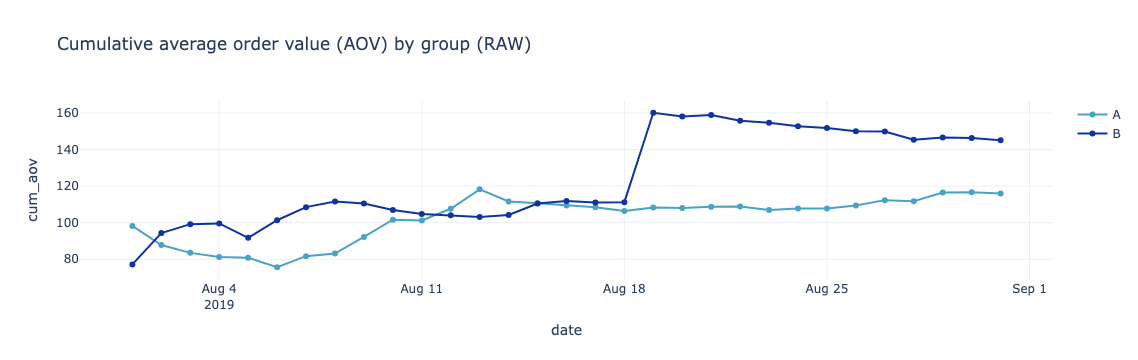

In [45]:
# Compute cumulative AOV (cum_revenue / cum_orders)
cumulativeData["cum_aov"] = cumulativeData["revenue"] / cumulativeData["orders"]
display(cumulativeData)

# Plot
fig = px.line(
    cumulativeData, x="date", y="cum_aov", color="group",
    title="Cumulative average order value (AOV) by group (RAW)"
)
fig.update_traces(
    mode="lines+markers",
    hovertemplate="Date=%{x|%Y-%m-%d}<br>Group=%{legendgroup}<br>Cum AOV=%{y:.2f}<extra></extra>"
)
fig.update_layout(legend_title_text="")
for tr in fig.data:
    tr.line.color = COLORS.get(tr.name, tr.line.color)

fig.show()

#### Findings

- **Group B keeps a higher cumulative AOV** for most of the period.
- There is a **sharp jump around ~Aug 19** in B — consistent with **one or a few very high-value orders**.
- After the jump, B’s cumulative AOV **drifts down slightly but remains above** A; A **stabilizes** without large swings.
- This suggests the revenue gap is driven at least partly by **higher order values** in B (not just more orders).
- **Conjecture:** B has a heavier tail (more high-ticket orders). We’ll verify via a **price scatter** and **95th/99th percentiles** to identify outliers, then re-check results on filtered data.

#### 3.3. Relative difference in cumulative AOV (B vs A), RAW — from split A/B

In [46]:
def build_rel_diff_cum_aov(cum_df):
    """
    Build a day-by-day table with cumulative AOV for A and B
    and the relative difference (B/A - 1).
    Expects cum_df to have columns: ['date', 'group', 'cum_aov'].
    Returns: DataFrame with ['date', 'cum_aov_B', 'cum_aov_A', 'rel_diff_B_vs_A'].
    """
    # Keep only what needed and rename for clarity
    cumulativeDataB = (cum_df.loc[cum_df['group'] == 'B', ['date', 'cum_aov']]
         .rename(columns={'cum_aov': 'cum_aov_B'}))
    cumulativeDataA = (cum_df.loc[cum_df['group'] == 'A', ['date', 'cum_aov']]
         .rename(columns={'cum_aov': 'cum_aov_A'}))

    # Align A and B by date
    merged_cumulative_AOV = cumulativeDataB.merge(cumulativeDataA, on='date', how='inner').sort_values('date')

    # Relative difference: (B/A - 1)
    merged_cumulative_AOV['rel_diff_B_vs_A'] = merged_cumulative_AOV['cum_aov_B'] / merged_cumulative_AOV['cum_aov_A'] - 1
    return merged_cumulative_AOV

merged_cumulative_AOV = build_rel_diff_cum_aov(cumulativeData)

# line chart
fig = px.line(
    merged_cumulative_AOV, x="date", y="rel_diff_B_vs_A", 
    title="Relative difference in cumulative AOV (B vs A), RAW"
)
fig.update_traces(
    mode="lines+markers",
    hovertemplate="Date=%{x|%Y-%m-%d}<br>B vs A: %{y:.2%}<extra></extra>"
)
fig.update_layout(yaxis_tickformat=".0%", legend_title_text="")
fig.add_hline(y=0, line_dash="dot")

fig.show()

# Final figure for the last day
print(f"Final relative diff (B vs A): {merged_cumulative_AOV['rel_diff_B_vs_A'].iloc[-1]:.2%}")

Final relative diff (B vs A): 25.17%


#### Findings

- The curve stays above 0% most of the time -> B’s cumulative AOV > A’s for the majority of the test.
- There’s a brief early dip below 0%, after which B moves above A and remains there.
- Around Aug 19 we observe a sharp jump (~+45%), coinciding with one/few very large orders in B (likely outliers).
- By the end, the gap is about +25% in favor of B.
- The spike likely inflates the magnitude; after outlier filtering the gap should shrink, but if the effect is real, B should still lead.

#### 3.4a. Daily conversion rate by group (RAW)

In [47]:
def conversion_daily(orders_df, visits_df):
    """
    Compute daily conversion per (date, group):
    - orders per day = unique transactionId
    - conversion = orders / visits (per day)
    Returns columns: date, group, orders, visits, conversion.
    """
    # Daily orders per (date, group)
    daily_orders = (orders_df
    .groupby(['date', 'group'], as_index=False)
    .agg(orders=('transactionId', 'nunique'))
               )
    
    # Merge with daily visits and sort chronologically
    daily = (daily_orders
    .merge(visits_df, on=['date', 'group'], how='inner')
    .sort_values(['group', 'date'])
                       )

    # Daily conversion
    daily['conversion'] = daily['orders'] / daily['visits']
   
    return daily

# Compute (RAW)
conv_daily = conversion_daily(orders_raw, visits)

# plot
fig = px.line(conv_daily, x="date", y="conversion", color="group",
              title="Daily conversion rate by group (RAW)")
fig.update_traces(mode="lines+markers",
                  hovertemplate="Date=%{x|%Y-%m-%d}<br>Group=%{legendgroup}<br>Conversion=%{y:.2%}<extra></extra>")
fig.update_layout(legend_title_text="", yaxis_tickformat=".1%")
for tr in fig.data:
    tr.line.color = COLORS[tr.name]
fig.show()


#### Findings
- Both groups show strong day-to-day volatility (~2%–6%).
- The lines cross often, so there is no persistent conversion leader.
- Group B has a few mid-month spikes, but the advantage is not stable.
- By the end, levels are close, suggesting only a small difference (if any).

**Note:** these are RAW results (include cross-group users); we’ll recheck on filtered data.

#### 3.4b. Cumulative conversion by group (RAW)

In [48]:
# Build cumulative conversion
cum = cumulativeData.copy()
cum['cum_conv'] = cum['orders'] / cum['visitors']

# Line chart for cumulative conversion
px.defaults.template = "plotly_white"

fig = px.line(
    cum, x='date', y='cum_conv', color='group',
    title='Cumulative conversion by group (RAW)'
)
fig.update_traces(
    mode='lines+markers',
    hovertemplate='Date=%{x|%Y-%m-%d}<br>Cum conv=%{y:.2%}<extra></extra>'
)
fig.update_layout(legend_title_text='', yaxis_tickformat='.1%', yaxis_title='cumulative conversion')
for tr in fig.data:
    tr.line.color = COLORS[tr.name]
fig.show()

#### Findings
- Early volatility fades; curves diverge and then run roughly in parallel, with B consistently above A.
- Over the final part of the test, the gap is stable (no large swings), indicating stabilization of cumulative conversion.

#### 3.5. Number of orders per user

In [49]:
def orders_per_user_by_group(orders_df):
    """
    Count unique orders per (group, visitorId) and give each group
    its own x-index so points don't overlap on the x-axis.
    """
    per_user = (orders_df
        .groupby(['group', 'visitorId'], as_index=False)
        .agg(orders=('transactionId', 'nunique')))
    per_user['user_idx'] = per_user.groupby('group').cumcount()
    return per_user

# Build table (RAW)
opu_raw_g = orders_per_user_by_group(orders_raw)

# Build scatter plot
px.defaults.template = "plotly_white"

fig = px.scatter(
    opu_raw_g, x='user_idx', y='orders', color='group',
    title='Orders per user by group (RAW)',
    hover_data=['visitorId', 'orders']
)
fig.update_traces(mode='markers', marker=dict(size=6, opacity=0.75))
fig.update_xaxes(title='users (per group index)', showticklabels=False)
fig.update_yaxes(title='orders per user', dtick=1)

for tr in fig.data:
    if 'COLORS' in globals():
        tr.marker.color = COLORS.get(tr.name, tr.marker.color)
fig.show()


#### Findings


- Distribution is heavily right-skewed: most users made 1 order.
- A small tail at 2–3 orders; only rare users with 4+ (max observed ~11).
- Clear high-order outliers are present. 

#### 3.6. Percentiles & anomaly cutoff — orders per user (RAW)

In [50]:
p95, p99 = np.percentile(opu_raw_g['orders'], [95, 99])

print(f"95th percentile: {p95:.0f}")
print(f"99th percentile: {p99:.0f}")

95th percentile: 2
99th percentile: 4


#### Findings
**Anomaly definition (orders per user).**  
We computed **P95 = 2** and **P99 = 4** orders/user. For an integer count metric, we mark a user as an outlier if their count is **strictly above P99**.  
**Rule:** **orders per user >= 5** -> anomaly.  
This targets roughly the top ~1% extreme cases, avoids flagging typical repeat buyers (2–3 orders), and yields a stable cutoff for filtering.

#### 3.7. Scatter — order prices

In [51]:
fig = px.scatter(
    orders_raw, x="date", y="revenue",
    title="Order prices over time (RAW)",
    hover_data=["transactionId", "visitorId", "revenue"]
)
fig.update_traces(
    mode="markers",
    marker=dict(size=6, opacity=0.8),
    hovertemplate="Date=%{x|%Y-%m-%d}<br>Order price=%{y:.2f}<extra></extra>"
)
fig.update_xaxes(title="date")
fig.update_yaxes(title="order price (revenue per order)", rangemode="tozero")
fig.show()

# Order prices without outliers (FILTERED view)
# Here we simply filter by the cutoff (<= 901).
price_cutoff = 901 
orders_no_outliers = orders_raw.loc[orders_raw["revenue"] <= price_cutoff].copy()

fig = px.scatter(
    orders_no_outliers, x="date", y="revenue", color="group",
    title=f"Order prices over time — no outliers (≤ {price_cutoff}), FILTERED"
)
fig.update_traces(
    mode="markers",
    marker=dict(size=6, opacity=0.8),
    hovertemplate="Date=%{x|%Y-%m-%d}<br>Order price=%{y:.2f}<extra></extra>"
)
fig.update_xaxes(title="date")
fig.update_yaxes(title="order price (revenue per order)", rangemode="tozero")

if "COLORS" in globals():
    for tr in fig.data:
        tr.marker.color = COLORS.get(tr.name, tr.marker.color)

fig.show()

#### Findings
- The distribution is **strongly right-skewed**: most orders fall in the lower range, while a **small number of very expensive orders** creates a long right tail.
- A few **extreme price points** appear around mid-August, which aligns with the earlier **jump in cumulative revenue/AOV**.
- Such high-price outliers can **inflate averages** and affect statistical tests; the main mass of orders remains relatively stable over time.
- Likely causes: **bulk baskets, premium items, or one-off promotions/campaigns**.
- Next step: compute **P95/P99 for order price** and set an **outlier cutoff** for filtered analysis.

#### 3.8. Percentiles & anomaly cutoff — order price (RAW)

In [52]:
p95, p99 = np.percentile(orders_raw['revenue'], [95, 99])

print(f"95th percentile: {p95:.0f}")
print(f"99th percentile: {p99:.0f}")

# anomaly rule for order price (continuous): strictly above P99
cutoff = p99
print(f"Anomaly cutoff: order price > {cutoff:.0f}")

flagged = (orders_raw['revenue'] > cutoff)
print(f"Flagged orders: {flagged.sum()} / {len(orders_raw)} ({flagged.mean():.2%})")

95th percentile: 436
99th percentile: 901
Anomaly cutoff: order price > 901
Flagged orders: 12 / 1197 (1.00%)


#### Findings
- The order-price distribution is **right-skewed**; computed percentiles: **P95 = 436**, **P99 = 901**.
- **Outlier rule:** mark an order as an anomaly if **order price > 901** (targets only the top ~1% tail).
- **Flagged orders:** 12 out of 1197 (**1.00%**), which trims only extreme values while preserving almost all data.
- This cutoff aligns with earlier spikes in high prices and will be used to build the **filtered** dataset for robustness checks in later steps.

#### 3.9. Statistical significance — conversion difference (RAW)

- **H0:** Conversion rates are equal in groups A and B (CR_A = CR_B).
- **H1:** Conversion rates differ between groups (CR_A ≠ CR_B).

**Operationalization:**  
To test conversion, build per-visitor samples where buyers contribute their order count (k ≥ 1) and non-buyers contribute **0**. This makes the sample mean equal to the group’s conversion (orders/visits).

**Test:** Mann–Whitney, **α = 0.05**. Reject H0 if *p* < 0.05.

In [53]:
def mwu_conversion(orders_df, visits_df, return_data=False):
    # Build "orders per visitor" samples for A and B
    ordersByUsersA = (
        orders_df[orders_df['group'] == 'A']
        .groupby('visitorId', as_index=False)
        .agg({'transactionId': pd.Series.nunique})
    )
    ordersByUsersA.columns = ['visitorId', 'orders']

    ordersByUsersB = (
        orders_df[orders_df['group'] == 'B']
        .groupby('visitorId', as_index=False)
        .agg({'transactionId': pd.Series.nunique})
    )
    ordersByUsersB.columns = ['visitorId', 'orders']

    # Total number of visitors (sum of daily visits) per group
    visitors_A = int(visits_df.loc[visits_df['group'] == 'A', 'visits'].sum())
    visitors_B = int(visits_df.loc[visits_df['group'] == 'B', 'visits'].sum())

    # Build samples:
    # - buyers contribute their number of orders (k >= 1)
    # - non-buyers contribute zeros so that len(sample) == total visitors
    sampleA = pd.concat(
        [ordersByUsersA['orders'],
         pd.Series(0, index=np.arange(visitors_A - len(ordersByUsersA)), name='orders')],
        ignore_index=True
    )
    sampleB = pd.concat(
        [ordersByUsersB['orders'],
         pd.Series(0, index=np.arange(visitors_B - len(ordersByUsersB)), name='orders')],
        ignore_index=True
    )

    # Mann–Whitney test on the distributions of "orders per visitor"
    p_val = stats.mannwhitneyu(sampleA, sampleB, alternative='two-sided').pvalue
    
    # Conversion levels (orders/visits) as the mean of each sample
    cr_A = sampleA.mean()
    cr_B = sampleB.mean()
    uplift = cr_B / cr_A - 1

    if return_data:
        # return scalars for external use (e.g., time-series build)
        return {'cr_A': float(cr_A), 'cr_B': float(cr_B),
                'uplift': float(uplift), 'p_value': float(p_val)}
    
    print(f"p-value: {p_val:.3f}")
    print(f"Relative uplift (B vs A): {uplift:.3f}")
    print("SIGNIFICANT at α=0.05" if p_val < 0.05 else "NOT significant at α=0.05")

In [54]:
mwu_conversion(orders_raw, visits)

# Collect cumulative metrics for each date
dates = sorted(visits['date'].unique())

uplift_ts_raw = pd.DataFrame([
    # For each date d, take data up to d and call the function once
    dict(date=d, **mwu_conversion(
    orders_raw[orders_raw['date'] <= d],
    visits[visits['date'] <= d],
    return_data=True
))
    for d in dates
])

# Plot
fig = px.line(
    uplift_ts_raw, x="date", y="uplift",
    title="Cumulative conversion uplift (B vs A) — RAW"
)
fig.update_traces(
    mode="lines+markers",
    hovertemplate="Date=%{x|%Y-%m-%d}<br>Uplift=%{y:.2%}<extra></extra>"
)
fig.update_layout(yaxis_tickformat=".0%", yaxis_title="uplift (B vs A)")
fig.add_hline(y=0, line_dash="dot")

if 'COLORS' in globals() and 'B' in COLORS:
    fig.update_traces(line_color=COLORS['B'], marker=dict(color=COLORS['B']))

fig.show()

p-value: 0.017
Relative uplift (B vs A): 0.138
SIGNIFICANT at α=0.05


#### Findings
- Test: Mann–Whitney on per-visitor order counts (zeros included for non-buyers).
- Result: **p = 0.02** (< 0.05) -> **statistically significant** difference between groups.
- Direction & magnitude: **Group B** shows a **~+13.8%** relative uplift in conversion vs **Group A**.
- Interpretation: On RAW data, **B outperforms A in conversion**. We will re-check robustness on the filtered dataset.

#### 3.10. AOV significance (RAW) — Mann–Whitney on per-order revenue

**Hypotheses:**  
H0: Average order value is equal in groups A and B (AOV_A = AOV_B).  
H1: Average order value differs between groups (AOV_A ≠ AOV_B).

**Operationalization:** compare per-order revenue distributions in A and B (RAW).  
**Test:** Mann–Whitney U, α = 0.05. Reject H0 if p < 0.05.

In [55]:
def mwu_aov(orders_df, return_data=False):
    # Per-order revenue by group (RAW)
    rev_A = orders_df.loc[orders_df['group'] == 'A', 'revenue']
    rev_B = orders_df.loc[orders_df['group'] == 'B', 'revenue']

    # Means and relative uplift
    aov_A = rev_A.mean()
    aov_B = rev_B.mean()
    uplift = aov_B / aov_A - 1

    # Mann–Whitney p-value
    p_val = stats.mannwhitneyu(rev_A, rev_B).pvalue

    if return_data:
        # Return scalars for plotting / time series
        return {'aov_A': float(aov_A), 'aov_B': float(aov_B),
               'uplift': float(uplift), 'p_value': float(p_val)}

    print(f"Relative uplift (B vs A): {uplift:.3f}")
    print(f"p-value: {p_val:.3f}")
    print("SIGNIFICANT at α=0.05" if p_val < 0.05 else "NOT significant at α=0.05")

In [56]:
mwu_aov(orders_raw)

# Build a cumulative time series: for each date D, use orders with date <= D
dates = sorted(orders_raw['date'].unique())

aov_uplift_ts_raw = pd.DataFrame([
    dict(date=d, **mwu_aov(orders_raw[orders_raw['date'] <= d], return_data=True))
    for d in dates
])

# Plot
fig = px.line(
    aov_uplift_ts_raw, x="date", y="uplift",
    title="Cumulative AOV uplift (B vs A) — RAW"
)
fig.update_traces(
    mode="lines+markers",
    hovertemplate="Date=%{x|%Y-%m-%d}<br>AOV uplift=%{y:.2%}<extra></extra>"
)
fig.update_layout(yaxis_tickformat=".0%", yaxis_title="AOV uplift (B vs A)")
fig.add_hline(y=0, line_dash="dot")

if 'COLORS' in globals() and 'B' in COLORS:
    fig.update_traces(line_color=COLORS['B'], marker=dict(color=COLORS['B']))

fig.show()

Relative uplift (B vs A): 0.252
p-value: 0.692
NOT significant at α=0.05


#### Findings
- Relative uplift (B vs A): **+25.2%**, but **p = 0.692 > 0.05** -> **not statistically significant**.
- Interpretation: on RAW data, there is **no reliable difference** in AOV between groups.
- Likely drivers: **right-skewed distribution** and **high-price outliers** inflate variance and reduce test power.
- Next: repeat the test on the **filtered** dataset (outliers removed) and optionally compare **median AOV** as a robust check.

#### 3.11a. Statistical significance — conversion difference (FILTERED)

**Hypotheses:**  
H0: Conversion rates are equal in groups A and B (CR_A = CR_B).  
H1: Conversion rates differ between groups (CR_A ≠ CR_B).

**Operationalization:** per-visitor samples where buyers contribute k ≥ 1 orders and non-buyers contribute 0; sample mean equals conversion. (FILTERED dataset.)  
**Test:** Mann–Whitney U, α = 0.05. Reject H0 if p < 0.05.

In [57]:
def remove_ab_anomalies(orders_df, user_orders_cutoff=5, price_cutoff=901):
    # Build per-user order counts (unique orders per visitor)
    usersWithManyOrders = (
        orders_df
        .groupby('visitorId', as_index=False)
        .agg({'transactionId': 'nunique'})
    )
    usersWithManyOrders.columns = ['visitorId', 'orders']

    # Apply filters:
    # - user-level: drop all orders of users with >= user_orders_cutoff orders
    # - order-level: keep only orders with price <= price_cutoff
    filtered = orders_df[
        (~orders_df['visitorId'].isin(
            usersWithManyOrders.loc[usersWithManyOrders['orders'] >= user_orders_cutoff, 'visitorId']
        )) &
        (orders_df['revenue'] <= price_cutoff)
    ].copy()

    print("Rows kept:", len(filtered))
    print("Max orders per user:", filtered.groupby('visitorId')['transactionId'].nunique().max())
    print(f"Any price > {price_cutoff} left?", (filtered['revenue'] > price_cutoff).any())

    return filtered

# Apply filters on top of the crossers-removed dataset
orders_filtered = remove_ab_anomalies(orders_filtered, 5, 901)

Rows kept: 1007
Max orders per user: 3
Any price > 901 left? False


In [58]:
# Conversion significance on FILTERED data
mwu_conversion(orders_filtered, visits)

dates = sorted(visits['date'].unique())

uplift_ts_f = pd.DataFrame([
    # for each date d: take data up to d and get metrics via the helper
    dict(date=d, **mwu_conversion(
        orders_filtered[orders_filtered['date'] <= d],
        visits[visits['date'] <= d],
        return_data=True
    ))
    for d in dates
])

# Line chart
fig = px.line(
    uplift_ts_f, x="date", y="uplift",
    title="Cumulative conversion uplift (B vs A) — FILTERED"
)
fig.update_traces(
    mode="lines+markers",
    hovertemplate="Date=%{x|%Y-%m-%d}<br>Uplift=%{y:.2%}<extra></extra>"
)
fig.update_layout(yaxis_tickformat=".0%", yaxis_title="uplift (B vs A)")
fig.add_hline(y=0, line_dash="dot")

if 'COLORS' in globals() and 'B' in COLORS:
    fig.update_traces(line_color=COLORS['B'], marker=dict(color=COLORS['B']))

fig.show()

p-value: 0.010
Relative uplift (B vs A): 0.164
SIGNIFICANT at α=0.05


#### Findings
- After filtering (remove users with **≥5** orders; drop orders with **price > 901**; remove crossers), the estimated uplift is **+16.4%**, with **p = 0.010 < 0.05** → **statistically significant**.
- Compared to RAW (p ≈ 0.017, uplift ≈ +13.8%), the effect becomes slightly stronger, consistent with high-tail noise being trimmed.
- Interpretation: on filtered data, **Group B** shows a **reliably higher conversion** than **Group A**.

#### 3.11b. Cumulative conversion by group (FILTERED)

In [59]:
# Build cumulative table on FILTERED orders
cumulativeData_f = build_cumulative_data(orders_filtered, visits)

# cum_conv = cumulative_orders / cumulative_visits
cum_f = cumulativeData_f.copy()
cum_f['cum_conv'] = cum_f['orders'] / cum_f['visitors']

px.defaults.template = "plotly_white"

fig = px.line(
    cum_f, x='date', y='cum_conv', color='group',
    title='Cumulative conversion by group (FILTERED)'
)
fig.update_traces(
    mode='lines+markers',
    hovertemplate='Date=%{x|%Y-%m-%d}<br>Cum conv=%{y:.2%}<extra></extra>'
)
fig.update_layout(legend_title_text='', yaxis_tickformat='.1%', yaxis_title='cumulative conversion')
for tr in fig.data:
    tr.line.color = COLORS[tr.name]
fig.show()

#### Findings
- On filtered data, both cumulative conversion curves stabilize in the second half of the test.
- Group B stays consistently above A with a fairly stable gap (~0.4–0.5 pp).

#### 3.12. Statistical significance — average order size (FILTERED)

**Hypotheses:**  
H0: Average order value is equal in groups A and B (AOV_A = AOV_B).  
H1: Average order value differs between groups (AOV_A ≠ AOV_B).

**Operationalization:** compare per-order revenue distributions in A and B on the FILTERED dataset.  
**Test:** Mann–Whitney U, α = 0.05. Reject H0 if p < 0.05.

In [60]:
# Note: orders_filtered = crossers removed + user-level (>=5) removed + orders with price >901 removed
mwu_aov(orders_filtered)

# Build a cumulative time series: for each date D, use orders with date <= D (FILTERED)
dates = sorted(orders_filtered['date'].unique())

aov_uplift_ts_f = pd.DataFrame([
    dict(date=d, **mwu_aov(orders_filtered[orders_filtered['date'] <= d], return_data=True))
    for d in dates
])

# Plot
fig = px.line(
    aov_uplift_ts_f, x="date", y="uplift",
    title="Cumulative AOV uplift (B vs A) — FILTERED"
)
fig.update_traces(
    mode="lines+markers",
    hovertemplate="Date=%{x|%Y-%m-%d}<br>AOV uplift=%{y:.2%}<extra></extra>"
)
fig.update_layout(yaxis_tickformat=".0%", yaxis_title="AOV uplift (B vs A)")
fig.add_hline(y=0, line_dash="dot")

if 'COLORS' in globals() and 'B' in COLORS:
    fig.update_traces(line_color=COLORS['B'], marker=dict(color=COLORS['B']))

fig.show()

Relative uplift (B vs A): -0.031
p-value: 0.934
NOT significant at α=0.05


#### Findings
- Relative uplift (B vs A): **−3.1%**
- **p = 0.934 > 0.05** -> **not statistically significant**
- Interpretation: no reliable difference in AOV between groups after filtering. The negative sign suggests B’s AOV is slightly lower than A’s, but this effect is indistinguishable from noise.

## Step 4. Final Decision 

**Recommendation:** It seems reasonable to **stop the experiment** and treat **Group B** as the likely winner.

**Why:**
- **Conversion:** B > A and statistically significant  
  - RAW: p ≈ 0.017, uplift ≈ **+13–14%**  
  - FILTERED: p ≈ 0.010, uplift ≈ **+16%**
- **AOV:** no reliable difference (RAW p ≈ 0.692; FILTERED p ≈ 0.934).
- **Stability:** cumulative conversion curves flatten in the tail; **B stays above A** without late reversals.

**What I’d do next:**

A gradual rollout is advisable: start with **partial exposure (~20–30%)** for several days and **monitor conversion, AOV, and revenue per visit** for stability. If metrics remain within expected bounds, proceed to **full exposure**.

*Note: filtered analysis was used (cross-group users removed; users with ≥5 orders excluded; orders with price > 901 removed).*

**Validity note:**  
A pre-calculation of the **required sample size** and **test duration** (via an A/B calculator) was not done here.  
Since the cumulative curves stabilized and B’s conversion uplift is significant at **α = 0.05**, stopping the test looks reasonable for this project.